# 1. Import Necessary Libraries

Make sure  Microsoft Visual C++ is installed on your pc

Extracting text from pdf and converting to csv

In [1]:
!pip install PyMuPDF


[notice] A new release of pip available: 22.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import fitz  # PyMuPDF
import os
import pandas as pd
import re

# Path to your directory containing the PDFs
doc_dir = r'C:\Users\Sadiksha\Documents\Back-Up Sadisksha\sadiksha\semester6\AI_project\studies\studies'

# List to store the blocks of text (as individual records)
data = []

# Function to check if a line is a heading (all uppercase or starts with 'CHAPTER')
def is_heading(line):
    return line.isupper() or line.startswith('CHAPTER')

# Function to check if a line is a footnote (starts with number in brackets, number, or asterisk)
def is_footnote(line):
    return re.match(r'^\[\d+\]', line) or re.match(r'^\d+\.', line) or line.startswith('*') or line.startswith('Note') or line.startswith('Table') 

# Function to count words in a block of text
def count_words(text):
    return len(text.split())

# Function to filter out lines containing DOI, URLs, specific keywords, or phrases
def contains_doi_or_https(line):
    return ('doi' in line.lower() or 
            'https' in line.lower() or 
            'http' in line.lower() or 
            'journal' in line.lower() or 
            'university' in line.lower() or 
            'brookville' in line.lower() or
            'to cite this article' in line.lower() or
            'full terms & conditions' in line.lower() or
            'taylor & francis' in line.lower() or
            'elsevier' in line.lower() or
            'published by' in line.lower() or
            'received' in line.lower() or
            'revised' in line.lower() or
            'author(s)' in line.lower() or
            'source:' in line.lower() or
            'history:' in line.lower() or
            'keywords' in line.lower() or
            'vol.' in line.lower() or 
            'volume' in line.lower() or 
            'downloaded' in line.lower() or    
            'article' in line.lower() or
            'creative commons use' in line.lower() or
            'author' in line.lower() or 
            'copyrighted' in line.lower() or
            'quarterly' in line.lower() or
            'journal' in line.lower() or
            'purtell' in line.lower() or
            'resources:' in line.lower() or
            'publisher' in line.lower() or
            'ying' in line.lower() or
            'cincinnati' in line.lower() or
            'ISSN' in line.lower() or
            'All rights reserved' in line.lower() or
            'authors' in line.lower())

# Function to check if a line is part of the reference or acknowledgements section
def is_reference_or_acknowledgements_section(line):
    reference_markers = ['references', 'bibliography', 'acknowledgements', 'nederlandse', 'method',"methods"]
    return any(marker in line.lower() for marker in reference_markers)

# Function to replace ligatures with their individual characters
def replace_ligatures(text):
    ligatures = {
        'ﬁ': 'fi',
        'ﬂ': 'fl',
        'ﬃ': 'ffi',
        'ﬄ': 'ffl',
        'ﬀ': 'ff',
        'ﬂ': 'fl',
    }
    for ligature, replacement in ligatures.items():
        text = text.replace(ligature, replacement)
    return text

# Function to fix common word splits
def fix_common_word_splits(text):
    common_fixes = {
        'signi ficant': 'significant',
        'di fferent': 'different',
        'e ffective': 'effective',
        'e ffect': 'effect',
        'chil dren': 'children',
        'e ff ective': 'effective',
        'con fi dence': 'confidence',
    }
    for split_word, correct_word in common_fixes.items():
        text = text.replace(split_word, correct_word)
    
    text = re.sub(r'\b(\w{3,})\s+(\w{3,})\b', r'\1 \2', text)  # Adjust spaces if needed
    return text

# Loop through each file in the directory
for filename in os.listdir(doc_dir):
    if filename.endswith('.pdf'):  # Only process PDF files
        file_path = os.path.join(doc_dir, filename)

        # Extract the title of the PDF (filename without the '.pdf' extension)
        title = os.path.splitext(filename)[0]

        # Open the PDF file using PyMuPDF
        pdf_document = fitz.open(file_path)

        # Flag to indicate if we are in the reference or acknowledgements section for the entire document
        section_reached = False

        # Iterate through each page in the PDF
        for page_num in range(pdf_document.page_count):
            if section_reached:
                break  # Stop processing further pages if the section marker was reached

            page = pdf_document.load_page(page_num)  # Load a page by page number
            text_dict = page.get_text("dict")  # Extract text in dictionary format to preserve layout
            
            # Substitute all semicolons (;) with commas (,)
            for block in text_dict["blocks"]:
                if block["type"] == 0:  # Type 0 is a text block
                    for line in block["lines"]:
                        for span in line["spans"]:
                            span["text"] = span["text"].replace(';', ',')
            
            # Process each block of text on the page
            for block in text_dict["blocks"]:
                if block["type"] == 0:  # Type 0 is a text block
                    block_text = ""
                    prev_x = None  # To store the previous x-coordinate (indentation level)
                    paragraph = []  # List to store lines that belong to the same paragraph

                    for line in block["lines"]:
                        # Get the text from the line
                        line_text = " ".join([span["text"] for span in line["spans"]])

                        # Apply ligature replacement and common word fixes
                        line_text = replace_ligatures(line_text)
                        line_text = fix_common_word_splits(line_text)

                        # **Immediately stop processing if the reference/acknowledgements section is detected**
                        if is_reference_or_acknowledgements_section(line_text):
                            section_reached = True
                            break  # Exit the inner loop and stop processing this file
                        
                        # Skip if it's a header, footnote, contains DOI/URL, or matches the title of the PDF
                        if is_heading(line_text) or is_footnote(line_text) or contains_doi_or_https(line_text) or line_text.strip().lower() == title.lower():
                            continue

                        # Get the x-coordinate (horizontal position of the first word in the line)
                        first_word_x = line["spans"][0]["bbox"][0]

                        # Check if the line belongs to the same paragraph (by horizontal position)
                        if prev_x is None or first_word_x - prev_x < 10:  # If the line's x is close to the previous, it's part of the same paragraph
                            paragraph.append(line_text)
                        else:
                            # When indentation changes significantly, treat this as the start of a new paragraph
                            if paragraph:  # If there's already accumulated text, store it as a block
                                full_paragraph_text = " ".join(paragraph).strip()
                                if count_words(full_paragraph_text) >= 10:  # Skip blocks with less than 10 words
                                    data.append([filename, page_num + 1, full_paragraph_text])
                            paragraph = [line_text]  # Start a new paragraph

                        prev_x = first_word_x  # Update the previous x-coordinate

                    # If section_reached is True after breaking, break the outer loop as well
                    if section_reached:
                        break

                    # If there's any accumulated paragraph, add it to the data
                    if paragraph and not section_reached:
                        full_paragraph_text = " ".join(paragraph).strip()
                        if count_words(full_paragraph_text) >= 10:  # Skip blocks with less than 10 words
                            data.append([filename, page_num + 1, full_paragraph_text])

# Convert the data to a DataFrame (optional)
df = pd.DataFrame(data, columns=["File", "Page", "text"])

# Print the first few records
print(df.head())


                                                File  Page  \
0  Advantages of mixed-age free play in elementar...     1   
1  Advantages of mixed-age free play in elementar...     2   
2  Advantages of mixed-age free play in elementar...     2   
3  Advantages of mixed-age free play in elementar...     2   
4  Advantages of mixed-age free play in elementar...     2   

                                                text  
0  mixed-age free play in elementary school: perc...  
1  Advantages of mixed-age free play in elementar...  
2  Mixed-age groups have been shown to be effecti...  
3  stakeholders expressed their support for cross...  
4  Most of us, and even most of our parents and g...  


In [3]:
# save the DataFrame to a CSV file
df.to_csv("studies_lobke.csv", index=False)

# 2.  Load Your Data

Load the articles from your CSV file using pandas. 

In [4]:
import pandas as pd

# Load the data
df= pd.read_csv(r'C:\Users\Sadiksha\Documents\Back-Up Sadisksha\sadiksha\semester6\AI_project\project\studies_lobke.csv')
df.head()

,File,Page,text
0,Advantages of mixed-age free play in elementar...,1,mixed-age free play in elementary school: perc...
1,Advantages of mixed-age free play in elementar...,2,Advantages of mixed-age free play in elementar...
2,Advantages of mixed-age free play in elementar...,2,Mixed-age groups have been shown to be effecti...
3,Advantages of mixed-age free play in elementar...,2,stakeholders expressed their support for cross...
4,Advantages of mixed-age free play in elementar...,2,"Most of us, and even most of our parents and g..."


### Removing any personal informtion to anonymize data  

### Use python 3.11.1 version

In [5]:
import spacy
import re
import pandas as pd

# Load spaCy model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

# Function to remove personal names, dates, and numbers
def remove_sensitive_info(text):
    if not isinstance(text, str):
        return ""  # Handle non-string values

    doc = nlp(text)

    # Remove PERSON names using spaCy NER
    words = [token.text for token in doc if token.ent_type_ != "PERSON"]

    # Remove dates and numbers
    cleaned_text = " ".join(words)
    cleaned_text = re.sub(r'\b\d{1,4}[-/]\d{1,2}[-/]\d{1,4}\b', '', cleaned_text)  # Remove dates (YYYY-MM-DD, DD/MM/YYYY)
    cleaned_text = re.sub(r'\b\d+\b', '', cleaned_text)  # Remove standalone numbers

    return cleaned_text.strip()

# Apply function to remove names, personal info, dates, and numbers from df['sentence_clean']
df['text_clean'] = df['text'].apply(remove_sensitive_info)

# Display cleaned dataframe
display(df.head())


,File,Page,text,text_clean
0,Advantages of mixed-age free play in elementar...,1,mixed-age free play in elementary school: perc...,mixed - age free play in elementary school : p...
1,Advantages of mixed-age free play in elementar...,2,Advantages of mixed-age free play in elementar...,Advantages of mixed - age free play in element...
2,Advantages of mixed-age free play in elementar...,2,Mixed-age groups have been shown to be effecti...,Mixed - age groups have been shown to be effec...
3,Advantages of mixed-age free play in elementar...,2,stakeholders expressed their support for cross...,stakeholders expressed their support for cross...
4,Advantages of mixed-age free play in elementar...,2,"Most of us, and even most of our parents and g...","Most of us , and even most of our parents and ..."


# 3. Prepare Your Text Data
We clean up the text
- Remove the name of city, country, geography for better outcome
- Remove special characters (only letters)
- Convert to lower case
- Remove stop words
- Remove words of only one or 2 letters ('a', 'I', at,...)
- Remove very short sentences
- Remove urls 
- use stemming
- do duplicate sentences




In [6]:
import spacy
import pandas as pd

# Load spaCy's English NER model
nlp = spacy.load("en_core_web_sm")

# Function to remove geographic entities (cities, countries, locations)
def remove_geographical_entities(text):
    if not isinstance(text, str):
        return ""  # Handle missing or non-string values
    
    doc = nlp(text)
    filtered_tokens = [token.text for token in doc if token.ent_type_ not in ["GPE", "LOC", "FAC"]]
    
    return " ".join(filtered_tokens)

# Apply function to remove cities, countries, and geography
df['text_clean'] = df['text'].apply(remove_geographical_entities)

# Display a few cleaned sentences
df.head()


,File,Page,text,text_clean
0,Advantages of mixed-age free play in elementar...,1,mixed-age free play in elementary school: perc...,mixed - age free play in elementary school : p...
1,Advantages of mixed-age free play in elementar...,2,Advantages of mixed-age free play in elementar...,Advantages of mixed - age free play in element...
2,Advantages of mixed-age free play in elementar...,2,Mixed-age groups have been shown to be effecti...,Mixed - age groups have been shown to be effec...
3,Advantages of mixed-age free play in elementar...,2,stakeholders expressed their support for cross...,stakeholders expressed their support for cross...
4,Advantages of mixed-age free play in elementar...,2,"Most of us, and even most of our parents and g...","Most of us , and even most of our parents and ..."


In [7]:
import re
import unicodedata
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import download
from collections import Counter

# Ensure necessary NLTK resources are downloaded
download('wordnet')
download('stopwords')

# Load stopwords
stop_words = set(stopwords.words('english'))

# Retain important stopwords (do NOT remove these)
important_stopwords = {
    # Negation Words (Critical for meaning)
    "not", "never", "nor", "no",
    # Modality Words (Possibility/Necessity)
    "can", "could", "should", "would", "may", "might", "must",
    # Quantifiers (Define amounts)
    "all", "any", "some", "many", "much", "few", "more", "most", "several", "less", "least",
    # Time References (Useful for context)
    "before", "after", "since", "until", "while", "when", "then",
    # Comparative Words (Relative meaning)
    "than", "as", "like"
}
# Remove all stopwords **except** the important ones
stop_words -= important_stopwords

# Minimum word length threshold
minWordSize = 2

# Initialize the WordNetLemmatizer and PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Preprocessing function to clean sentences
def preprocess_text(text):
    if not isinstance(text, str):
        return ""  # Handle missing or non-string values

    # Normalize Unicode characters
    text = unicodedata.normalize('NFKD', text)

    # Convert text to lowercase and split into words
    words = text.lower().split()

    # Remove stopwords except for retained important ones
    filtered_words = [word for word in words if word not in stop_words]

    # Apply lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    # Apply stemming after lemmatization
    stemmed_words = [stemmer.stem(word) for word in lemmatized_words]

    # Remove short words after stopword removal, except retained important words
    final_words = [w for w in stemmed_words if len(w) >= minWordSize or w in important_stopwords]

    # Remove duplicate words within each sentence (preserving order)
    unique_words = list(dict.fromkeys(final_words))

    # Ensure proper spacing between words
    return " ".join(unique_words)

# Apply preprocessing function to clean sentences
df['text_clean'] = df['text_clean'].apply(preprocess_text)

# Display the first elements after processing
df.head()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sadiksha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sadiksha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,File,Page,text,text_clean
0,Advantages of mixed-age free play in elementar...,1,mixed-age free play in elementary school: perc...,mix age free play elementari school percept st...
1,Advantages of mixed-age free play in elementar...,2,Advantages of mixed-age free play in elementar...,advantag mix age free play elementari school p...
2,Advantages of mixed-age free play in elementar...,2,Mixed-age groups have been shown to be effecti...,mix age group shown effect classroom set hand ...
3,Advantages of mixed-age free play in elementar...,2,stakeholders expressed their support for cross...,stakehold express support cross age interact m...
4,Advantages of mixed-age free play in elementar...,2,"Most of us, and even most of our parents and g...",most even parent grandpar grew age segreg scho...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   File        512 non-null    object
 1   Page        512 non-null    int64 
 2   text        512 non-null    object
 3   text_clean  512 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.1+ KB


### To see how data cleaning looks 

In [9]:
import os

# Define the filename for the cleaned data
output_filename = "cleaned_data.csv"

# Get the current folder path
current_folder = os.getcwd()

# Full path to save the file
output_path = os.path.join(current_folder, output_filename)

# Save the cleaned DataFrame to CSV
df.to_csv(output_path, index=False, encoding='utf-8')

print(f"✅ Cleaned data saved at: {output_path}")

✅ Cleaned data saved at: c:\Users\Sadiksha\Documents\Back-Up Sadisksha\sadiksha\semester6\AI_project\project\cleaned_data.csv


### Read the clean data 

In [10]:
import pandas as pd

# Load the data
df= pd.read_csv(r'C:\Users\Sadiksha\Documents\Back-Up Sadisksha\sadiksha\semester6\AI_project\project\cleaned_data.csv')
df.head()

,File,Page,text,text_clean
0,Advantages of mixed-age free play in elementar...,1,mixed-age free play in elementary school: perc...,mix age free play elementari school percept st...
1,Advantages of mixed-age free play in elementar...,2,Advantages of mixed-age free play in elementar...,advantag mix age free play elementari school p...
2,Advantages of mixed-age free play in elementar...,2,Mixed-age groups have been shown to be effecti...,mix age group shown effect classroom set hand ...
3,Advantages of mixed-age free play in elementar...,2,stakeholders expressed their support for cross...,stakehold express support cross age interact m...
4,Advantages of mixed-age free play in elementar...,2,"Most of us, and even most of our parents and g...",most even parent grandpar grew age segreg scho...


# 4. Initialize and Fit BERTopic
The good thing with BERTopic is that is does most of the work automatically (Meaning, I do not need to bore you to death with details about how it works behind te scenes.)

We need to do 3 things
1. Initialize BERTopic model
2. 'Fit' the model -> this  means: run the model, as you would run a simple linear regression
3. Look at the topics via 

To get started, let's just use the default settings.

In [11]:
!pip install bertopic[all]



[notice] A new release of pip available: 22.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize BERTopic model
topic_model = BERTopic(calculate_probabilities=True)

# Fit the model with preprocessed text sentences
topics, probabilities = topic_model.fit_transform(df['text_clean'])

# View and inspect topics
topic_model.get_topic_info()


c:\Users\Sadiksha\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


,Topic,Count,Name,Representation,Representative_Docs
0,-1,232,-1_child_age_classroom_mix,"[child, age, classroom, mix, develop, group, s...",[not surprisingli consider attent focus way fa...
1,0,102,0_classroom_child_literaci_age,"[classroom, child, literaci, age, preschool, y...",[anoth notabl featur classroom may shape liter...
2,1,53,1_play_age_social_mix,"[play, age, social, mix, child, group, more, y...",[spent less time parallel play mixed- than age...
3,2,50,2_care_caregiv_child_group,"[care, caregiv, child, group, qualiti, studi, ...",[mix age classroom instanc younger child mixed...
4,3,25,3_pleas_contact_correspond_childhood,"[pleas, contact, correspond, childhood, avail,...",[mccall macomb common ground publish usa ambig...
5,4,24,4_interact_teacher_classroom_behavior,"[interact, teacher, classroom, behavior, probl...",[teacher child interact qualiti may vari depen...
6,5,16,5_preschool_social_classroom_peer,"[preschool, social, classroom, peer, interact,...",[montessori ’s 1912 approach earli childhood c...
7,6,10,6_languag_younger_skill_classroom,"[languag, younger, skill, classroom, level, be...",[discuss previou research indic child languag ...


In [13]:
# Initialize BERTopic model
topic_model = BERTopic(calculate_probabilities=True, min_topic_size=5, nr_topics=10)

# Fit the model with preprocessed text sentences
topics, probabilities = topic_model.fit_transform(df['text_clean'])

# View and inspect topics
topic_model.get_topic_info()



,Topic,Count,Name,Representation,Representative_Docs
0,-1,198,-1_child_age_classroom_develop,"[child, age, classroom, develop, mix, group, o...",[younger child benefit expos model behavior ol...
1,0,158,0_classroom_child_age_peer,"[classroom, child, age, peer, teacher, prescho...",[recent research shown age composit preschool ...
2,1,39,1_care_caregiv_child_qualiti,"[care, caregiv, child, qualiti, group, studi, ...",[educ level profession caregiv also frequent r...
3,2,37,2_program_use_educ_digit,"[program, use, educ, digit, pleas, jstor, avai...",[accomplish goal studi use data educar impleme...
4,3,28,3_play_solitari_parallel_age,"[play, solitari, parallel, age, mix, playmat, ...",[goldman 1981 examin form so- cial particip cl...
5,4,18,4_social_age_particip_group,"[social, age, particip, group, same, mix, chil...",[while not major focu studi few research prese...
6,5,10,5_magnuson_expans_duncan_last,"[magnuson, expans, duncan, last, critic, 2013,...",[earli childhood year present critic window op...
7,6,10,6_moral_attend_center_care,"[moral, attend, center, care, understand, beha...",[studi report re- searcher hypothes preschool ...
8,7,7,7_multigrad_old_attend_year,"[multigrad, old, attend, year, class, 2010, 20...",[five year old attend multigrad classroom demo...
9,8,7,8_emerg_environ_literaci_physic,"[emerg, environ, literaci, physic, outcom, chi...",[preschool classroom age composit physic liter...


In [14]:
topic_model.topics_[:20]

[3, 3, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, -1]

### Here we reduce the number of topics with the number of pdf files we have uploaded

In [15]:
print(topic_model.topics_)

[3, 3, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, -1, 1, -1, 3, -1, -1, 1, -1, 1, -1, 0, -1, 0, 0, -1, -1, 0, 0, -1, -1, 0, 0, 0, 0, -1, 0, 0, -1, -1, 2, 5, 0, -1, -1, 0, 0, 0, -1, -1, -1, -1, 0, -1, 0, 0, -1, 4, -1, -1, 5, 0, -1, -1, -1, 0, 0, 5, -1, 0, 0, -1, -1, 0, 0, 0, -1, -1, -1, 5, -1, 0, -1, 0, -1, -1, -1, -1, -1, -1, 0, -1, 2, -1, -1, 0, 0, -1, 0, 0, 0, -1, 0, 0, -1, -1, 1, -1, 0, 0, -1, -1, -1, 0, -1, -1, 0, -1, 0, 0, 0, 3, -1, 2, -1, 0, -1, -1, 0, -1, -1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 2, 0, -1, -1, 5, 0, 0, -1, -1, 1, -1, 0, -1, 2, -1, -1, -1, 2, 2, 1, -1, 1, -1, 0, -1, 2, -1, 3, 3, 3, 3, 3, 3, 7, 1, 4, 3, 2, -1, 3, 3, 3, 3, 3, -1, -1, 3, 4, -1, 5, -1, -1, 3, 3, 3, -1, -1, 1, 1, -1, 2, 1, -1, 0, -1, -1, 0, 0, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, -1, 0, 2, -1, 6, 6, 4, -1, 6, 2, 1, 6, -1, 2, 6, 6, 6, 1, 6, 6, 6, 0, 0, 2, 1, 7, 7, 4, -1, 7, -1, -1, -1, -1, 7, 0, 0, 2, -1, -1, -1, -1, 0, 0, -1, -1, -1,

### Here we can search an attribute that is related to certain topics

In [16]:
similar_topics, similarity = topic_model.find_topics("stress"); similar_topics

[8, 1, 4, -1, 3]

In [17]:
similar_topics, similarity = topic_model.find_topics("happy"); similar_topics

[2, 3, 7, 5, 4]

In [18]:
topic_model.get_topic(6)

[('moral', np.float64(0.1564700900656136)),
 ('attend', np.float64(0.09038433281059044)),
 ('center', np.float64(0.07280515108673169)),
 ('care', np.float64(0.06672390760887227)),
 ('understand', np.float64(0.0650638996417945)),
 ('behavior', np.float64(0.06430403847603217)),
 ('preschool', np.float64(0.05908400073873381)),
 ('child', np.float64(0.05705904442394501)),
 ('mix', np.float64(0.05433527638907706)),
 ('age', np.float64(0.05076505583212936))]

### topic limited to the pdf count

In [19]:
topic_model.get_topic(30)

False

# 5. Visualize Topics
We can call .visualize_topics to create a 2D representation of the topics. The  graph is a plotly interactive graph which can be converted to HTML:

Note: If you get the error 'ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed', go to terminal and type 'pip install --upgrade nbformat  ' 

In [20]:
# Visualize topics with an interactive plot
topic_model.visualize_topics()

You can use the slider to select the topic which then lights up red. If you hover over a topic, then general information is given about the topic, including the size of the topic and its corresponding words.

We can also ask for a representation of the corresponding words for each topic:

In [21]:
topic_model.visualize_barchart()

# 6. Visualize Topic Hierarchy¶
The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. We can also see what happens to the topic representations when merging topics. 

In [22]:
hierarchical_topics = topic_model.hierarchical_topics(df['text_clean'])
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)


100%|██████████| 8/8 [00:00<00:00, 228.16it/s]


If you hover over the black circles, you will see the topic representation at that level of the hierarchy. These representations help you understand the effect of merging certain topics. Some might be logical to merge whilst others might not. Moreover, we can now see which sub-topics can be found within certain larger themes.

You can also print a text-version of the topic representation at the different levels (a bit less pretty, but maybe easier to read.)

In [23]:
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)


.
├─child_age_classroom_studi_mix
│    ├─■──emerg_environ_literaci_physic_outcom ── Topic: 8
│    └─child_age_classroom_studi_mix
│         ├─child_age_classroom_studi_mix
│         │    ├─play_age_social_mix_group
│         │    │    ├─■──play_solitari_parallel_age_mix ── Topic: 3
│         │    │    └─■──social_age_particip_group_same ── Topic: 4
│         │    └─child_classroom_age_studi_interact
│         │         ├─■──classroom_child_age_peer_teacher ── Topic: 0
│         │         └─■──care_caregiv_child_qualiti_group ── Topic: 1
│         └─■──moral_attend_center_care_understand ── Topic: 6
└─program_year_earli_educ_childhood
     ├─program_educ_childhood_earli_expans
     │    ├─■──program_use_educ_digit_pleas ── Topic: 2
     │    └─■──magnuson_expans_duncan_last_critic ── Topic: 5
     └─■──multigrad_old_attend_year_class ── Topic: 7



# 7. Visualize documents

We can visualize the documents (=texts) inside the topics to see if they were assigned correctly or whether they make sense. To do so, we can use the topic_model.visualize_documents() function. This function recalculates the document embeddings and reduces them to 2-dimensional space for easier visualization purposes. 

In [24]:
df = df.reset_index(drop=True)  # Reset index to avoid KeyError
topic_model.visualize_documents(df['text'].tolist())  # Convert Series to list


When you hover over a point, you can see which text it is. The color tells you to which topic it belongs. While this is very pretty, it might be useful to be able to just open an excel-file or csv, which contains the original text, with the assigned topic, including the topic words:

In [25]:
import numpy as np
# Add topics and probabilities to the original DataFrame
df["topic_number"] = np.argmax(probabilities, axis=1)

# Also extract the topic names and assign them to the DataFrame
info = topic_model.get_topic_info()
topic_names = info['Representation']

df['topic_name'] = df['topic_number'].map(topic_names)

# Save the updated DataFrame to a CSV

df['topic_name'] = df['topic_number'].map(topic_names)

# Save to a new CSV file
df.to_csv("studies_lobke_with_topics.csv", index=False)


In [26]:
df.head()

,File,Page,text,text_clean,topic_number,topic_name
0,Advantages of mixed-age free play in elementar...,1,mixed-age free play in elementary school: perc...,mix age free play elementari school percept st...,3,"[program, use, educ, digit, pleas, jstor, avai..."
1,Advantages of mixed-age free play in elementar...,2,Advantages of mixed-age free play in elementar...,advantag mix age free play elementari school p...,0,"[child, age, classroom, develop, mix, group, o..."
2,Advantages of mixed-age free play in elementar...,2,Mixed-age groups have been shown to be effecti...,mix age group shown effect classroom set hand ...,0,"[child, age, classroom, develop, mix, group, o..."
3,Advantages of mixed-age free play in elementar...,2,stakeholders expressed their support for cross...,stakehold express support cross age interact m...,0,"[child, age, classroom, develop, mix, group, o..."
4,Advantages of mixed-age free play in elementar...,2,"Most of us, and even most of our parents and g...",most even parent grandpar grew age segreg scho...,0,"[child, age, classroom, develop, mix, group, o..."


We can also see the topic distribution per document = the probability that the text belongs to each topic (if a topic is not included in the graph, the probability is 0). Eg, the topic distribution for the sixth document:(!python starts counting at 0, so 6th =5)

In [27]:
topic_model.visualize_distribution(probabilities[5])

# 8. Topics per full article

We extract the number of times a topic is assigned within the full articles.

                                                    Topic 0  Topic 1  Topic 2  \
File                                                                            
Advantages of mixed-age free play in elementary...       23        3        0   
Classroom Age Composition and Preschoolers’ Sch...       17        0        0   
Classroom Age Composition and Vocabulary Develo...       12        0        0   
Classroom Age Composition and the schoolreadine...       10        0        0   
Classroom age composition and preschoolers’ lan...       20        0        0   
Classroom age composition and the early learnin...       18        0        0   
Classroom_age_composition_and_developmental cha...       12        1        0   
Collaborative literacy activity in print-enrich...       16        0        1   
Comparing peer interactions, teacher child inte...       17        0        0   
Continuity and changes in classroom age composi...       11        1        0   
Does mixing age groups in ea

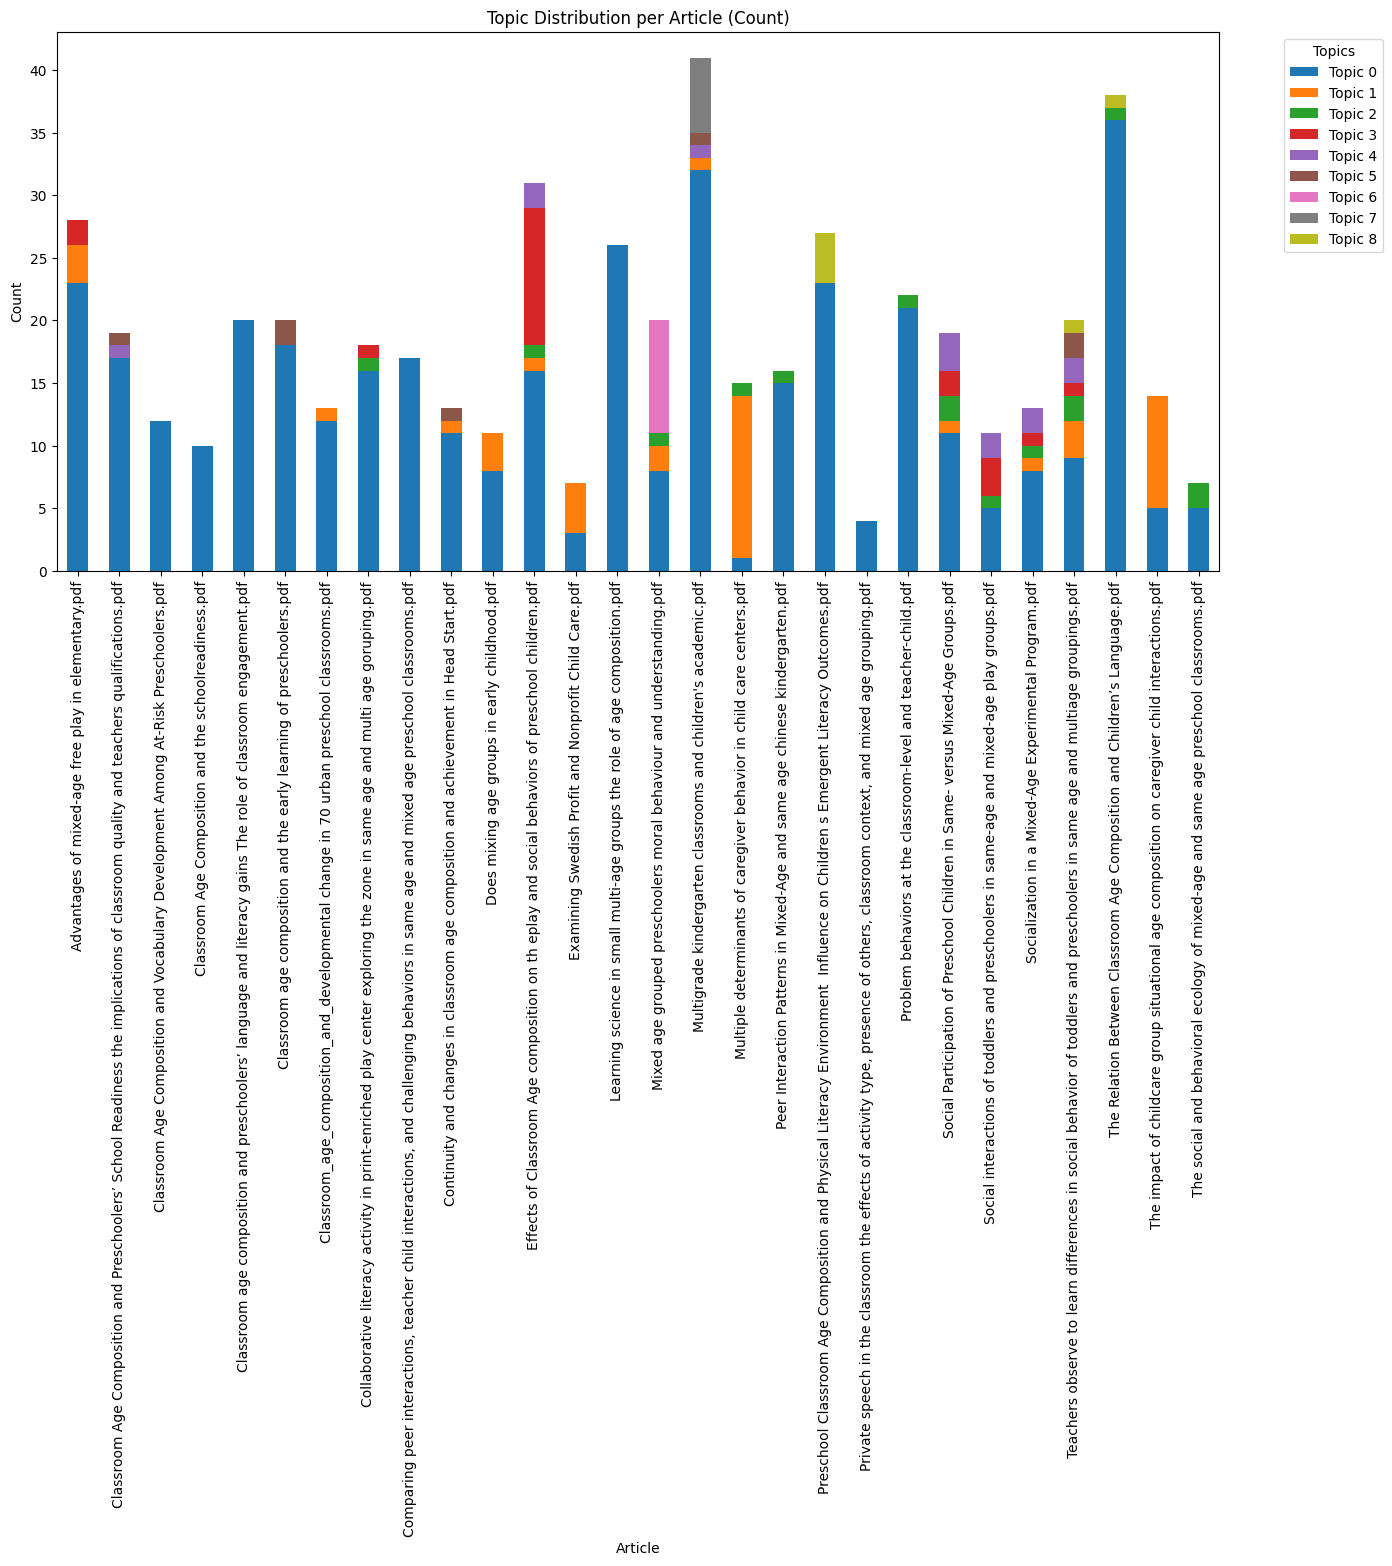

In [28]:
import matplotlib.pyplot as plt

# Calculate the count of times each topic is chosen within each article
article_topic_counts = df.groupby('File')['topic_number'].value_counts().unstack(fill_value=0)

# Rename columns to 'Topic X'
article_topic_counts.columns = [f'Topic {i}' for i in article_topic_counts.columns]

# Display the table
print(article_topic_counts)

# Plot the distribution for each article
article_topic_counts.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title('Topic Distribution per Article (Count)')
plt.xlabel('Article')
plt.ylabel('Count')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We could also do the same, but with proportions in stead of counts.

                                                     Topic 0   Topic 1  \
File                                                                     
Advantages of mixed-age free play in elementary...  0.821429  0.107143   
Classroom Age Composition and Preschoolers’ Sch...  0.894737  0.000000   
Classroom Age Composition and Vocabulary Develo...  1.000000  0.000000   
Classroom Age Composition and the schoolreadine...  1.000000  0.000000   
Classroom age composition and preschoolers’ lan...  1.000000  0.000000   
Classroom age composition and the early learnin...  0.900000  0.000000   
Classroom_age_composition_and_developmental cha...  0.923077  0.076923   
Collaborative literacy activity in print-enrich...  0.888889  0.000000   
Comparing peer interactions, teacher child inte...  1.000000  0.000000   
Continuity and changes in classroom age composi...  0.846154  0.076923   
Does mixing age groups in early childhood.pdf       0.727273  0.272727   
Effects of Classroom Age composition o

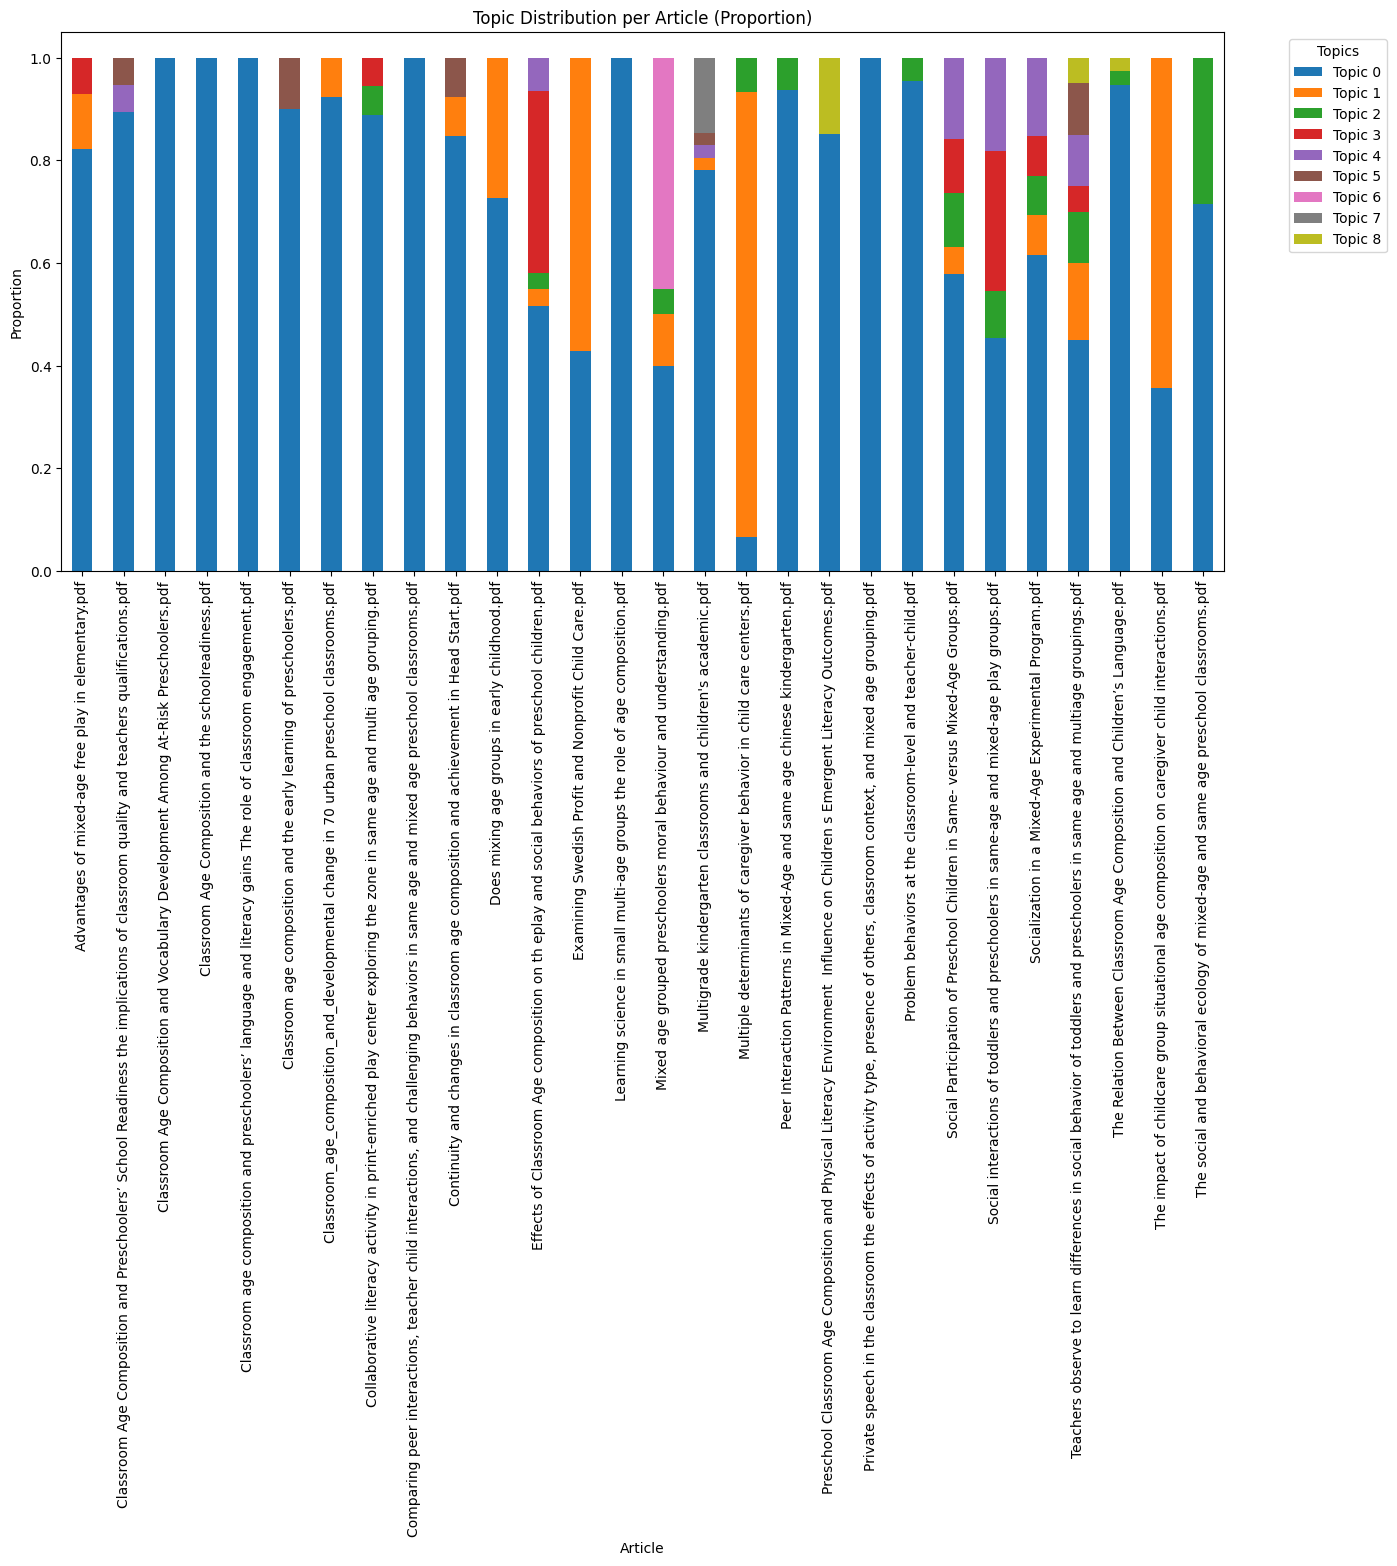

In [29]:
import matplotlib.pyplot as plt

# Calculate the proportion of times each topic is chosen within each article
article_topic_proportions = df.groupby('File')['topic_number'].value_counts(normalize=True).unstack(fill_value=0)

# Rename columns to 'Topic X'
article_topic_proportions.columns = [f'Topic {i}' for i in article_topic_proportions.columns]

# Display the table
print(article_topic_proportions)

# Plot the distribution for each article
article_topic_proportions.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title('Topic Distribution per Article (Proportion)')
plt.xlabel('Article')
plt.ylabel('Proportion')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

 The highest related topic is child_classroom_behavior it makes sense because we are working with data to see how childeren change of what effects the psychology of child after finishing the elementary school and entering to high school.

In [30]:
import nbformat
from nbconvert import PythonExporter

# Replace 'YourNotebookName.ipynb' with the actual filename of your notebook.
notebook_filename = "BERTtopic.ipynb"  
output_filename = notebook_filename.replace(".ipynb", ".py")

# Read the notebook file
with open(notebook_filename, encoding="utf-8") as f:
    nb_node = nbformat.read(f, as_version=4)

# Use PythonExporter to convert the notebook to a Python script
python_exporter = PythonExporter()
(script, resources) = python_exporter.from_notebook_node(nb_node)

# Write the converted Python code to a .py file
with open(output_filename, "w", encoding="utf-8") as f:
    f.write(script)

print(f"Notebook has been saved as {output_filename}")


Notebook has been saved as BERTtopic.py
